#### In this notebook we use pre-trained Inception V4 with validation set, and training only the last layer with dropout of .2, default dropout of fastai is .25 and .5 in the next layer

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pandas as pd
import numpy as np

In [3]:
PATH = "data/dogbreed/"
# size of images 340 x 340
sz = 340

arch = inception_4

# batch size
bs = 160

!ls {PATH}

400_inception_4_V2_submission.csv	models			   test.zip
DOGS_submission_inception4_val_top.csv	sample_submission.csv	   tmp
labels.csv				sample_submission.csv.zip  train
labels.csv.zip				test			   train.zip


In [5]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1

val_idxs = [get_cv_idxs(n)]
print("Validation set size is", len(val_idxs[0]))

Validation set size is 2044


### Initial model

In [6]:
# Helps us itterate faster by changing images from small to big
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs, # Create train/validation set
                                    suffix='.jpg',
                                    tfms=tfms,
                                    bs=bs)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [7]:
# Load our data sets
%time data = get_data(sz, bs)

# Create our simple model, no data augmentation.
# Precomputing weigths
learn = ConvLearner.pretrained(arch, data, ps=0.2, precompute=True)

CPU times: user 400 ms, sys: 16 ms, total: 416 ms
Wall time: 417 ms


In [8]:
# Our last layer architecture
learn

Sequential(
  (0): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.2)
  (2): Linear(in_features=3072, out_features=512)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.2)
  (6): Linear(in_features=512, out_features=120)
  (7): LogSoftmax()
)

In [9]:
# Find the best learning rate
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.5801     23.483061  0.501939  



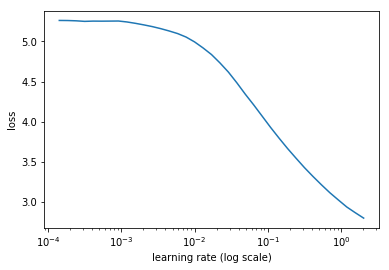

In [10]:
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.547503   0.278158   0.926225  
    1      0.310078   0.273847   0.925326                  
    2      0.222045   0.283093   0.927047                  
    3      0.176008   0.269905   0.928551                  
    4      0.150294   0.246946   0.92835                   
    5      0.130479   0.248236   0.932056                  
    6      0.107385   0.281726   0.930413                  

CPU times: user 16.2 s, sys: 13.6 s, total: 29.8 s
Wall time: 21.3 s


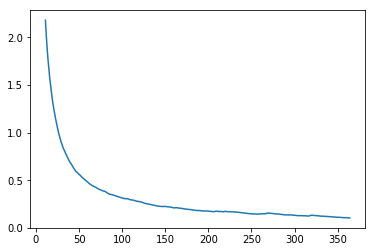

In [11]:
# Training is very fast with precomputed weights only the last layer
%time learn.fit(1e-1,7)

# Plot loss training
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.130575   0.229578   0.936523  
    1      0.123541   0.228907   0.9346                    
    2      0.12312    0.223808   0.938446                  
    3      0.121633   0.223312   0.937143                  
    4      0.125617   0.225592   0.937965                  
    5      0.115302   0.224687   0.936042                  
    6      0.115974   0.2239     0.934941                  
    7      0.115574   0.224905   0.934321                  
    8      0.1171     0.223476   0.936042                  
    9      0.115374   0.225385   0.937004                  

CPU times: user 36min 10s, sys: 5min 9s, total: 41min 20s
Wall time: 14min 4s


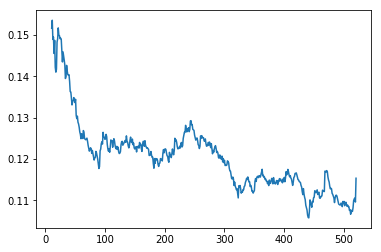

In [12]:
# Usign cycle_len=1 means stochastic gradient descent with restarts used only once during the training.
# Disable precompute and train last layer
learn.precompute = False

%time learn.fit(1e-2, 5, cycle_len=2)

# Plot loss 
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.113178   0.223664   0.936383  
    1      0.110808   0.224085   0.934941                  
    2      0.11243    0.224753   0.937826                  
    3      0.112332   0.225877   0.93446                   
    4      0.112328   0.22435    0.936523                  
    5      0.110298   0.225293   0.934941                  
    6      0.102221   0.223681   0.936383                  
    7      0.105587   0.223563   0.937004                  
    8      0.111545   0.225962   0.936523                  
    9      0.110908   0.225005   0.935561                  
    10     0.107683   0.223921   0.937004                  
    11     0.106195   0.225576   0.93446                   
    12     0.106107   0.224492   0.93446                   
    13     0.105165   0.226562   0.935422                  

CPU times: user 50min 23s, sys: 6min 9s, total: 56min 33s
Wall time: 19min 7s


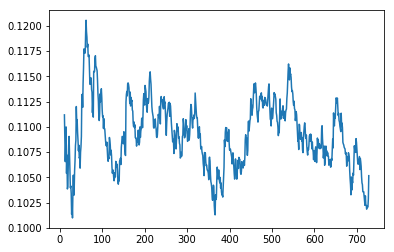

In [13]:
# Reduce our learning rate and use cycle nult
%time learn.fit(0.005, 3, cycle_len=2, cycle_mult=2)

# Plot loss
learn.sched.plot_loss()

In [15]:
# Save our model
learn.save('DOGS_inception4_val_top')

#### Submiting just using this model gave us score of  on LB 0.22227

### Retrain our model, UNFREEZING all layers and using differential lr.

In [9]:
lr = 1e-2

# Differential learning rates
lrs = np.array([lr/9,lr/3,lr])

# Train all layers in network
learn.unfreeze()

In [10]:
%time learn.fit(lrs, 3, cycle_len=2, cycle_mult=2)
learn.sched.plot_loss()

learn.save('DOGS_inception4_val_all')

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.317077   0.345953   0.907561  
    1      0.17659    0.307133   0.914685                    
    2      0.196117   0.3641     0.899082                    
    3      0.148972   0.335045   0.911014                    
    4      0.095364   0.316319   0.912937                     
    5      0.069276   0.309204   0.916302                     
    6      0.09684    0.35475    0.902841                     
    7      0.088426   0.366901   0.905726                     
    8      0.077182   0.364413   0.907561                     
    9      0.048951   0.331701   0.911976                     
    10     0.036719   0.339597   0.916696                     
    11     0.034072   0.336533   0.917177                     
    12     0.036713   0.32545    0.917657                     
    13     0.027609   0.328077   0.920061                     

CPU times: user 1h 14min 21s, sys: 9min 6s, total: 1h 23min 27s
Wall time: 47

#### Submiting just using this model gave us score of  on LB.

### Retrain our model on all data w/o validation set, and only on top layer.

In [15]:
# Set val data to 1 point
val_idxs = [0]


# Helps us itterate faster by changing images from small to big
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs, # Create train/validation set
                                    suffix='.jpg',
                                    tfms=tfms,
                                    bs=bs)
    
    return data if sz>300 else data.resize(340, 'tmp')

# Load our data sets
%time data = get_data(sz, bs)

# Freeze all but the last layer
learn.freeze()

CPU times: user 380 ms, sys: 20 ms, total: 400 ms
Wall time: 398 ms


In [16]:
%time learn.fit(1e-2, 6, cycle_len=2)

# Plot loss 
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=12), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.019694   0.325293   0.921503  
    1      0.016524   0.32664    0.919187                     
    2      0.01821    0.324619   0.921984                     
    3      0.019351   0.323949   0.92111                      
    4      0.020564   0.324824   0.921897                     
    5      0.017497   0.324023   0.920061                     
    6      0.020149   0.324168   0.921503                     
    7      0.01656    0.324303   0.922465                     
    8      0.018959   0.324204   0.921504                     
    9      0.014886   0.322802   0.921504                     
    10     0.012651   0.32747    0.922465                     
    11     0.015814   0.327967   0.920061                     

CPU times: user 43min 19s, sys: 6min 55s, total: 50min 14s
Wall time: 17min 13s


In [ ]:
# Reduce our learning rate and use cycle nult
%time learn.fit(0.005, 3, cycle_len=2, cycle_mult=2)

# Plot loss
learn.sched.plot_loss()

In [ ]:
learn.save('DOGS_inception4_noval_all')

### Retrain our model on all data, UNFREEZING all layers.

### Make our predictions

In [12]:
# Set precompute=Flse activations were previously generated based on our validation set and training set split
# learn = ConvLearner.pretrained(arch, data, precompute=False)
# learn.load('400_inception_4_no_val')

%time log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

CPU times: user 2min 28s, sys: 31.2 s, total: 2min 59s
Wall time: 57.9 s


(10357, 120)

In [13]:
# Convert to probs
preds = np.exp(log_preds_test)

df = pd.DataFrame(preds)
df.columns = data.classes

df.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])

# compression="gzip"
#df.to_csv(f'{PATH}DOGS_submission_inception4_val_top.csv', index=False)

df.to_csv(f'{PATH}DOGS_submission_inception4_val_all.csv', index=False)
#df.to_csv(f'{PATH}DOGS_submission_inception4_noval_top.csv', index=False)
#df.to_csv(f'{PATH}DOGS_submission_inception4_noval_all.csv', index=False)

from IPython.display import FileLink
FileLink(f'{PATH}DOGS_submission_inception4_val_all.csv')

In [14]:
from IPython.display import FileLink
FileLink(f'{PATH}DOGS_submission_inception4_val_all.csv')

/home/paperspace/fastai/courses/dl1/data/dogbreed/DOGS_submission_inception4_val_all.csv